In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
from pymongo import MongoClient
from bson.objectid import ObjectId
import time,datetime
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    data = [d for d in cursor]
    # print('In',str(col))
    count = 0
    for dic in data:
#         if 'o2_value' and 'hr_value' in dic.keys():
#             if (dic['longitude'] != 0) and (dic['longitude'] != '') and (dic['latitude'] != '') \
#                             and (dic['o2_value'] != '') and (dic['hr_value']!= ''):
        if 'hr_value' in dic.keys():
            if dic['hr_value']  != '':
                clean_data.append(dic)

In [8]:
import os 
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt

In [11]:
clean_data[0]

{'_id': ObjectId('5c88be22c4e5a626a3d9e610'),
 'hour': 16,
 'year': 2019,
 'hr_value': '67',
 'step_value': '0',
 'longitude': '',
 'minute': 24,
 'second': 0,
 'latitude': '',
 'month': 3,
 'day': 13,
 'o2_value': '96',
 'timestamp': 1552465440.0}

In [28]:
float_data = np.zeros((len(clean_data),6))
dic = {3:0, 4:1, 5:2, 8:3, 11:4, 12: 5}
for i, line in enumerate(clean_data):
    for j, (key, value) in enumerate(line.items()):
        if j in [3, 4, 5, 8, 11, 12]:
            if value != '':
                float_data[i,dic[j]]=float(value)
            else:
                float_data[i,dic[j]]=0

In [6]:
len(clean_data)

13054

In [ ]:
[hr_value, step_value, longitude, latitude, o2_value, timestamp]

In [31]:
mean = float_data[:13054].mean(axis=0)
float_data -= mean
std = float_data[:13054].std(axis=0)
float_data /= std

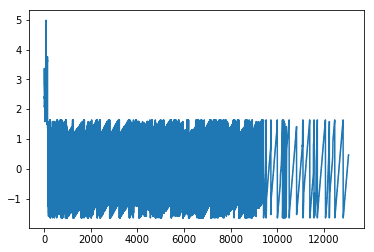

In [33]:
temp = float_data[:,0]
plt.plot(range(len(temp)), temp)

In [34]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=12):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indicies = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indicies]
            targets[j] = data[rows[j] + delay][2]
        yield samples, targets

In [40]:
lookback = 24*5
step = 12
delay = 24
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=6000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=6000,
                    max_index=8000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=8000,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (8000 - 6000 -lookback) // batch_size

test_steps = (len(float_data) - 8001 - lookback) // batch_size

In [36]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [37]:
evaluate_naive_method()
celsius_mae = 0.29 * std[1]

0.6374762299809393


In [38]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1381 - val_loss: 0.0902
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0803 - val_loss: 0.0612
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0672 - val_loss: 0.0621
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0600 - val_loss: 0.0384
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0544 - val_loss: 0.0444
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0500 - val_loss: 0.0381
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0390
Epoch 8/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0426 - val_loss: 0.0328
Epoch 9/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0397 - val_loss: 0.0306
Epoch 10/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0379 - val_loss: 0.0290

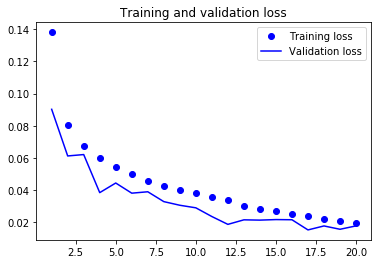

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()